# Μηχανική Μάθηση ~ Εργασία 3

### Θοδωρής Τσιρπάνης (`dai19090`)

---

## Προετοιμασία και φόρτωση δεδομένων

Εισάγουμε κάποιες βιβλιοθήκες που θα χρειαστούν σε ολόκληρο το notebook.

Αρκετός κώδικας είναι βασισμένος στον κώδικα των εργαστηρίων του μαθήματος, αλλά και των προηγούμενων εργασιών.

Στο ίδιο κελί φορτώνουμε και το dataset.

In [ ]:
import numpy as np
np.set_printoptions(precision=3)
from IPython.display import display, Markdown
from sklearn.datasets import fetch_openml

random_seed = 184

X, y_str = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

Χρησιμοποιούμε ένα αντικείμενο `LabelEncoder` για να μετατρέψουμε τους χαρακτήρες ASCII του y σε αριθμούς, και χωρίζουμε τα X και y σε training και test set, κατά την εκφώνηση.

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEnc = LabelEncoder()
y = labelEnc.fit_transform(y_str)

X_train = X[:60000,:]
y_train = y[:60000]
X_test = X[60000:,:]
y_test = y[60000:]

## Εκπαίδευση

Καθ' όλην τη διάρκεια της εργασίας, θα εκπαιδεύουμε τυχαία δάση. Τα δεδομένα δε χρειάζονται κάποιας μορφής κλιμάκωση· όντας ασπρόμαυρα pixel μιας εικόνας το εύρος τιμών τους ήδη περιορίζεται στο $[0, 255]$.

Πριν αρχίσουμε την εκπαίδευση, ορίζουμε κάποιες βοηθητικές συναρτήσεις.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import time

def make_randomForest():
  return RandomForestClassifier(random_state = random_seed, n_estimators = 50)

def calc_error_rate(model, X, y):
  return 1 - accuracy_score(y, model.predict(X))

def train_timed(model, X):
  start_time = time.time()
  model.fit(X, y_train)
  end_time = time.time()
  return end_time - start_time

def trainCV_timed(model, X):
  start_time = time.time()
  crossValScores = cross_val_score(model, X, y_train, scoring = calc_error_rate, cv = 5)
  end_time = time.time()
  return (end_time - start_time, np.mean(crossValScores))

def evaluate(model, X, y):
  y_predicted = model.predict(X)
  error_rate = calc_error_rate(model, X, y)
  return error_rate

def display_report(name, time, error_rate):
  display(Markdown(
    f"""### {name}
Training took **{time:.2f}** seconds.<br>
Error rate: **{error_rate:.2%}**"""
))

### Εκπαίδευση στο ανεπεξέργαστο training set

In [ ]:
model_randomForest_raw = make_randomForest()
time_randomForest_raw = train_timed(model_randomForest_raw, X_train)

In [ ]:
display_report("Random Forest - raw data", time_randomForest_raw, evaluate(model_randomForest_raw, X_test, y_test))

### Random Forest - raw data
Training took **22.56** seconds.<br>
Error rate: **3.27%**

### Ανάλυση Κυρίων Συνιστωσών

Δημιουργούμε ένα αντικείμενο `PCA` και το εκπαιδεύουμε στο training set. Μετασχηματίζουμε επίσης και το test set για μελλοντική χρήση.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(random_state = random_seed)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Εμφανίζουμε το ποσοστό της ερμηνευόμενης διακύμανσης της πρώτης συνιστώσας, και στη συνέχεια ένα γράφημα των πρώτων διακοσίων. Χρησιμοποιούμε λογαριθμική κλίμακα στον άξονα y επειδή οι τιμές μειώνονται δραματικά όσο πηγαίνουμε σε λιγότερο σημαντικές συνιστώσες.

> __Παρατήρηση__: Δε φαίνεται εδώ, αλλά εμφανίζοντας στο γράφημα _όλες_ τις συνιστώσες, παρατηρούμε γύρω στην εφτακοσιοστή δέκατη μια ξαφνική μείωση του ποσοστού από $10^{-10}$ σε $10^{-30}$.

The first principal component has **9.70%** of variance.

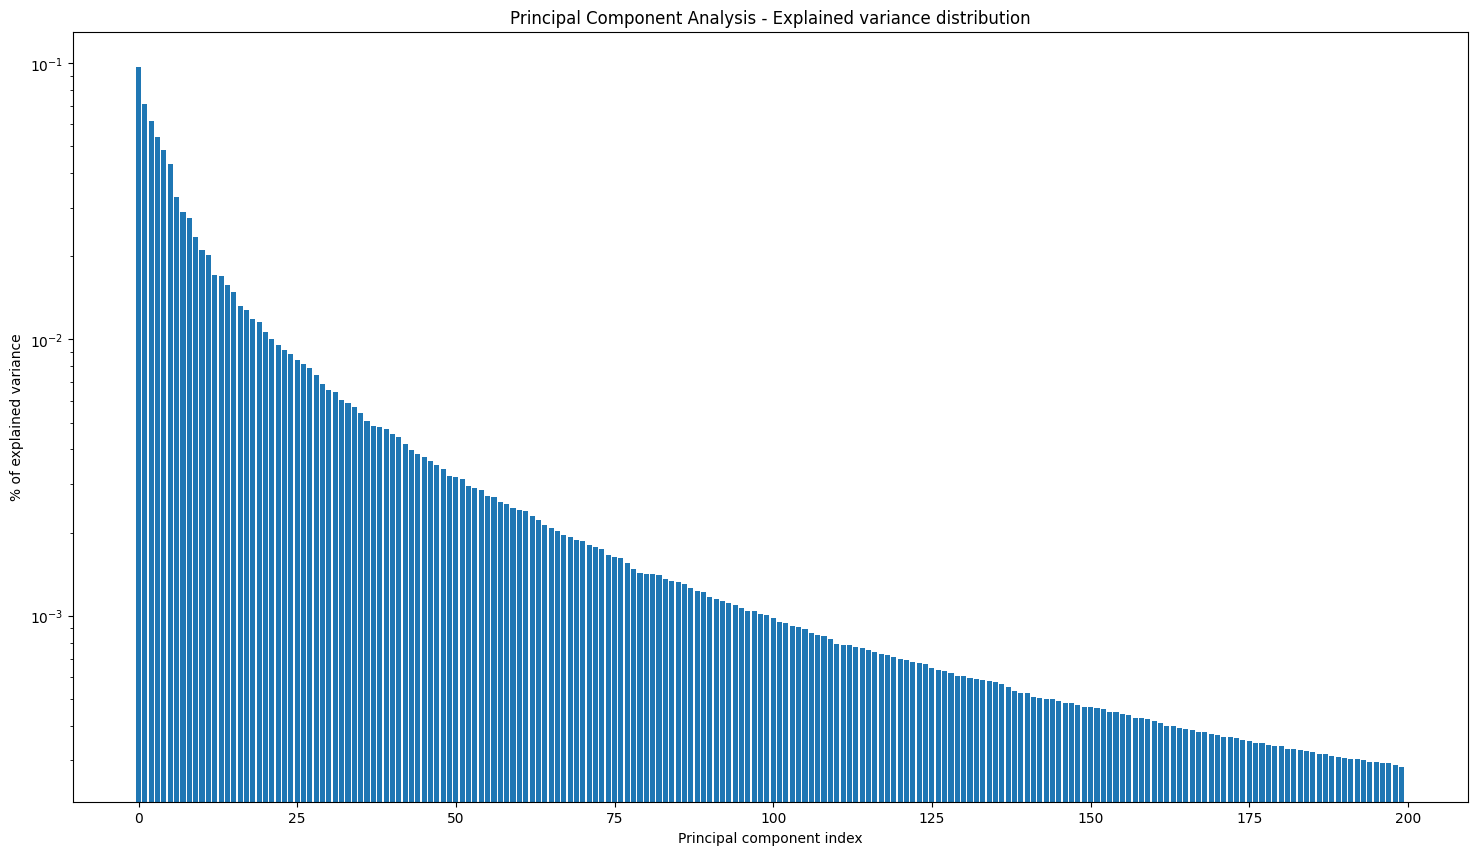

In [ ]:
import matplotlib.pyplot as plt

display(Markdown(f"The first principal component has **{pca.explained_variance_ratio_[0]:.2%}** of variance."))

def display_pca_bar():
  data = pca.explained_variance_ratio_[:200]

  plt.rcdefaults()
  fig = plt.figure(figsize=(18, 10))
  plt.title("Principal Component Analysis - Explained variance distribution")
  plt.xlabel("Principal component index")
  plt.ylabel("% of explained variance")
  plt.yscale("log")
  plt.bar(range(len(data)), data)
  plt.show()

display_pca_bar()

Εκπαιδεύουμε ένα τυχαίο δάσος στα δεδομένα που περάσαμε από PCA, κρατώντας όλες τις διαστάσεις.

In [ ]:
model_randomForest_pca = make_randomForest()
time_randomForest_pca = train_timed(model_randomForest_pca, X_train_pca)

In [ ]:
display_report("Random Forest - PCA - all dimensions", time_randomForest_pca, evaluate(model_randomForest_pca, X_test_pca, y_test))

### Random Forest - PCA - all dimensions
Training took **148.71** seconds.<br>
Error rate: **10.45%**

### Σύγκριση αριθμού συνιστωσών

Εκπαιδεύουμε με cross-validation τυχαία δάση στις πρώτες $n$ συνιστώσες, και καταγράφουμε τους ρυθμούς σφάλματος, τις ερμηνευόμενες διακυμάνσεις και τους χρόνους εκπαίδευσης.

In [ ]:
ns = list(range(5, 105, 5))

error_rates = []
explained_variances = []
training_times = []

for n in ns:
  print(f"n = {n}")
  model = make_randomForest()
  data_X = X_train_pca[:,:n]
  training_time, score = trainCV_timed(model, data_X)
  error_rates.append(score)
  explained_variances.append(np.sum(pca.explained_variance_ratio_[:n]))
  training_times.append(training_time)

n = 5
n = 10
n = 15
n = 20
n = 25
n = 30
n = 35
n = 40
n = 45
n = 50
n = 55
n = 60
n = 65
n = 70
n = 75
n = 80
n = 85
n = 90
n = 95
n = 100


Εμφανίζουμε τα αποτελέσματα σε ένα γράφημα. Κλιμακώνουμε τον χρόνο εκπαίδευσης εφαρμόζοντας ένα χειροκίνητο `MinMaxScaler` (επειδή το εν λόγω αντικείμενο δε λειτουργεί με μονοδιάστατα δεδομένα).

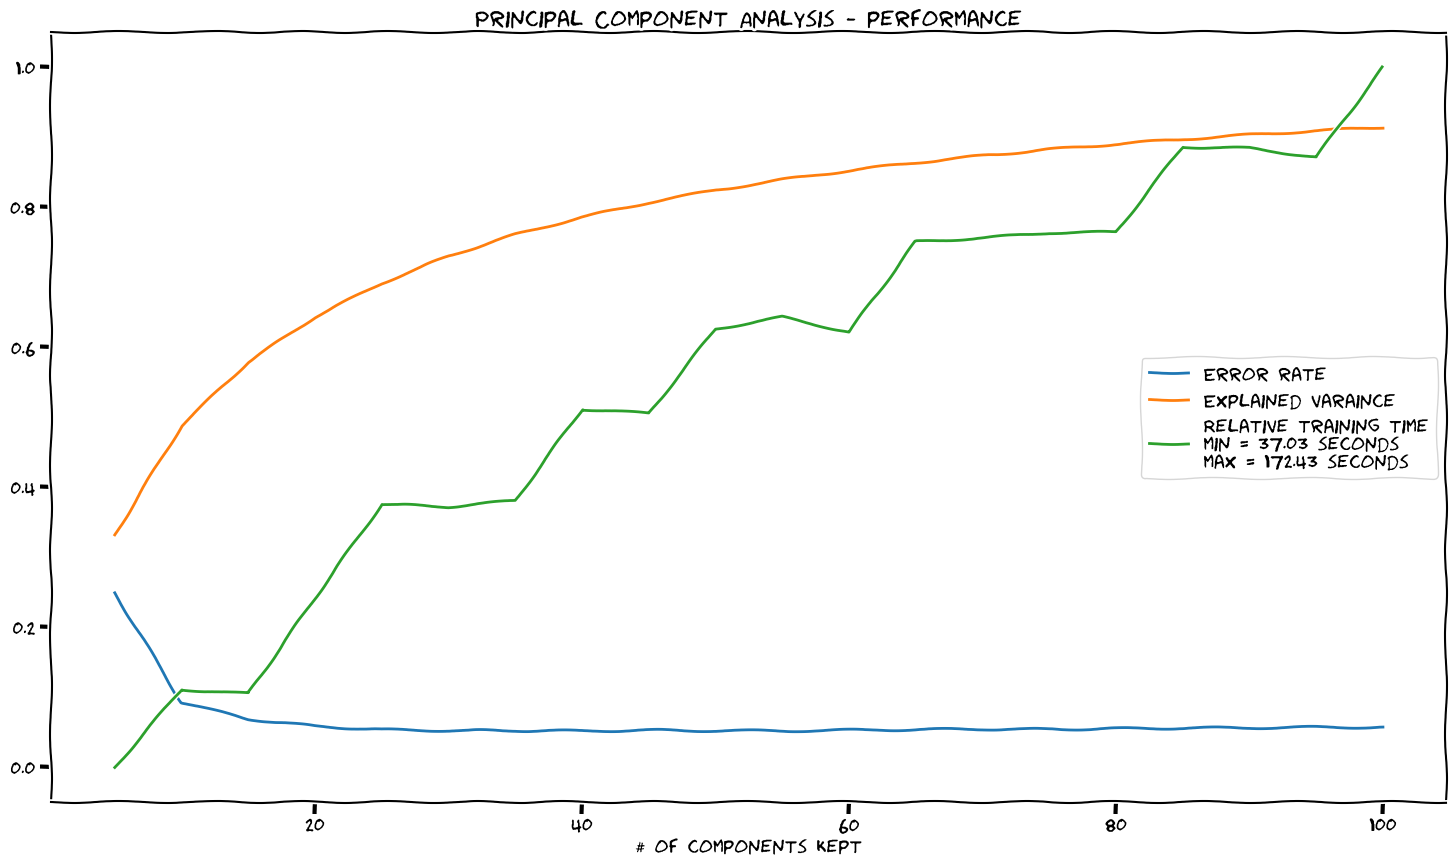

In [ ]:
training_times_array = np.array(training_times)
training_times_scaled = np.divide(np.subtract(training_times_array, np.min(training_times_array)), np.subtract(np.max(training_times_array), np.min(training_times_array)))

def display_pca_plot():
  plt.rcdefaults()
  fig = plt.figure(figsize=(18, 10))
  # M.Z. <3 για το meme rate!
  plt.xkcd() # Κάνει την ίσια γραμμή του error rate δυσανάγνωστη, αλλά αυξάνει σημαντικά το meme rate. 
  plt.title("Principal Component Analysis - performance")
  plt.xlabel("# of components kept")
  plt.plot(ns, error_rates, label = "Error rate")
  plt.plot(ns, explained_variances, label = "Explained varaince")
  plt.plot(ns, training_times_scaled, label = f"Relative training time\nmin = {np.min(training_times_array):.2f} seconds\nmax = {np.max(training_times_array):.2f} seconds")
  plt.legend(loc = "right")
  plt.show()
  pass

display_pca_plot()

### Τελική Ταξινόμηση

Για την τελική ταξινόμηση εκπαιδεύουμε τις $n = 40$ πρώτες συνιστώσες του training set και εμφανίζουμε τα αποτελέσματα.

In [ ]:
selected_n = 40

model_randomForest_pca_n = make_randomForest()
time_randomForest_pca_n = train_timed(model_randomForest_pca_n, X_train_pca[:,:selected_n])

In [ ]:
display_report(f"Random Forest - PCA - first {selected_n} dimensions", time_randomForest_pca_n, evaluate(model_randomForest_pca_n, X_test_pca[:,:selected_n], y_test))

### Random Forest - PCA - first 40 dimensions
Training took **27.54** seconds.<br>
Error rate: **4.93%**

## Συμπεράσματα

* Συγκρίνοντας τα μοντέλα με βάση τον χρόνο εκπαίδευσης, πρώτα ήταν στα ακατέργαστα δεδομένα, μετά με PCA στις σαράντα πρώτες συνιστώσες, και τέλος με PCA σε όλες τις συνιστώσες.
* Τελικά δεν βοήθησε η PCA σε αυτό το dataset. Έκανε την εκπαίδευση πιο αργή χωρίς να βελτιώσει τα αποτελέσματα.